In [11]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

# pd.set_option("display.max_column", 999)
# print(os.listdir("../input"))

# Load the data!

In [12]:
# DATA_PATH = '../data/'

# tourney_results = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MNCAATourneyDetailedResults.csv"),
#     pd.read_csv(DATA_PATH + "womens/WNCAATourneyDetailedResults.csv"),
# ], ignore_index=True)

# seeds = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MNCAATourneySeeds.csv"),
#     pd.read_csv(DATA_PATH + "womens/WNCAATourneySeeds.csv"),
# ], ignore_index=True)

# regular_results = pd.concat([
#     pd.read_csv(DATA_PATH + "mens/MRegularSeasonDetailedResults.csv"),
#     pd.read_csv(DATA_PATH + "womens/WRegularSeasonDetailedResults.csv"),
# ], ignore_index=True)


In [13]:
# regular_results.groupby('Season').mean()

In [14]:
# tourney_results.groupby('Season').mean()

In [15]:
# all(regular_results.columns == tourney_results.columns)

# Data preparation!

In [16]:
# regular_results_swap = regular_results[[
#     'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
#     'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
#     'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [17]:
# regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
# regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
# regular_results.columns.values[6] = 'location'
# regular_results_swap.columns.values[6] = 'location'

In [18]:
# regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
# regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [19]:
# regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [20]:
"""
tourney_results = pd.read_csv('../input/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/WRegularSeasonDetailedResults.csv')
"""
DATA_PATH = '../data/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "womens/WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "womens/WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "womens/WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [21]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature engineering!

In [22]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [23]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/1527646356.py:1: FutureWarning: The provided callable <function mean at 0x10d03fd80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/1527646356.py:2: FutureWarning: The provided callable <function mean at 0x10d03fd80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


In [24]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [25]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [26]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [27]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [28]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [29]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(20268, 5)

In [30]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [31]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [32]:
np.exp(2)

7.38905609893065

In [33]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encount

In [34]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [35]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [36]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [37]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [38]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [39]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [40]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4552.000000
mean        0.000000
std        17.479045
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [41]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [42]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [43]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [44]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [45]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.40894+0.05953	test-mae:13.41326+0.23926


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47240+0.03685	test-mae:9.72067+0.17239
[100]	train-mae:9.09705+0.04170	test-mae:9.56916+0.16537
[150]	train-mae:8.86261+0.04494	test-mae:9.54165+0.16977
[200]	train-mae:8.66621+0.04716	test-mae:9.52474+0.16887
[214]	train-mae:8.61407+0.04869	test-mae:9.52777+0.17063
Fold repeater 1
[0]	train-mae:13.40732+0.07736	test-mae:13.41009+0.30047


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46375+0.05124	test-mae:9.71679+0.18506
[100]	train-mae:9.09089+0.05206	test-mae:9.57243+0.22497
[150]	train-mae:8.85566+0.04912	test-mae:9.55278+0.23977
[200]	train-mae:8.65915+0.05278	test-mae:9.55513+0.24956
[204]	train-mae:8.64465+0.05088	test-mae:9.55527+0.24627
Fold repeater 2
[0]	train-mae:13.41214+0.05334	test-mae:13.41973+0.23319


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46931+0.04771	test-mae:9.71781+0.17626
[100]	train-mae:9.09359+0.06076	test-mae:9.54807+0.21980
[150]	train-mae:8.86015+0.06067	test-mae:9.51946+0.22914
[186]	train-mae:8.71459+0.06564	test-mae:9.51669+0.22851


In [46]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([189, 180, 162], [9.521677649368693, 9.54832231497496, 9.514513555085292])

In [47]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.31756306e+01  1.19542475e+01  5.54570246e+00  2.31451340e+01
  1.30874510e+01 -8.73710990e-01  1.03224678e+01 -8.77582073e+00
 -4.94383669e+00 -9.30564880e-01 -2.51314044e+00 -1.64618921e+00
  5.77498913e+00  2.39756584e+00  1.79516888e+01  4.00092030e+00
  3.13796139e+00  1.64755154e+00 -1.95179653e+00  7.17732477e+00
  2.01544971e+01 -7.27670312e-01  3.44393039e+00  3.12407589e+01
  8.77628613e+00 -2.80814195e+00  1.77529602e+01  5.98336077e+00
  1.08807240e+01  3.56282473e+00  1.34747324e+01 -9.10497904e-01
  5.06562424e+00  3.46293402e+00 -3.866

Fold repeater 1


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.06430187e+01  1.72257023e+01  4.02533627e+00  2.14774303e+01
 -3.09399676e+00  1.65121708e+01  2.18830929e+01  1.39668808e+01
  1.32645721e+01  2.72303200e+00  8.93340397e+00 -2.38226748e+00
 -4.59146929e+00 -6.23392200e+00 -2.98429966e+00  2.72834468e+00
  1.27389030e+01  1.92165012e+01  9.63693500e-01  8.69887948e-01
  6.27605343e+00  7.18585825e+00 -7.86863995e+00  7.37282097e-01
  5.13604450e+00  4.97829866e+00 -8.38659942e-01  2.90096688e+00
  4.17959541e-02 -2.83046508e+00  5.75341749e+00 -3.98768210e+00
  1.34280455e+00  2.44172516e+01  1.820

Fold repeater 2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.40129924e+00 -7.60032940e+00  1.77186593e-01  4.23154783e+00
 -9.90886211e+00  1.40022647e+00 -2.63934159e+00 -1.48773932e+00
  8.35546875e+00 -5.06340551e+00 -8.29804122e-01  3.59507227e+00
 -2.79286623e+00 -2.34115553e+00  2.15838032e+01  8.39658546e+00
 -2.98346186e+00  2.54556489e+00  1.32605572e+01  6.83803034e+00
  4.22734499e+00  1.64169769e+01 -8.27457047e+00  3.04272151e+00
  3.69954610e+00 -7.74933910e+00 -1.89638793e+00  4.12498617e+00
  3.21739435e-01  6.31048012e+00 -7.33817160e-01  4.09661722e+00
  1.32765265e+01  6.19986248e+00  3.109

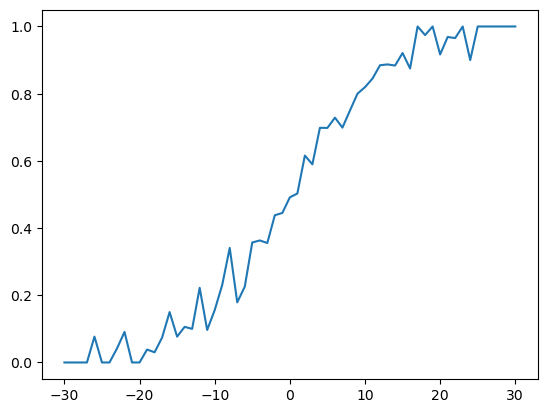

In [48]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [49]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5119777391775344
logloss of cvsplit 1: 0.5137680324011386
logloss of cvsplit 2: 0.5124309527896247


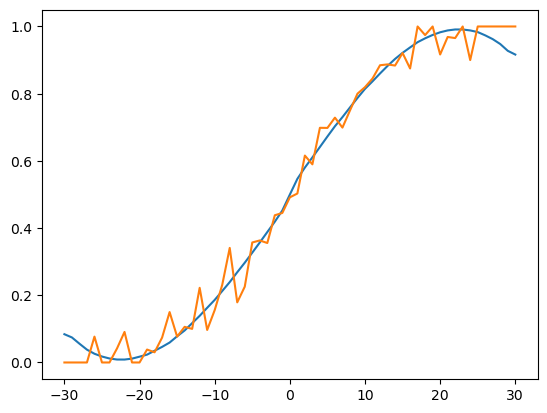

In [51]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [52]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5108409166382848
adjusted logloss of cvsplit 1: 0.512929234192677
adjusted logloss of cvsplit 2: 0.510702974293594


In [53]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.0700892952510073
adjusted logloss of cvsplit 1: 1.0717212828192109
adjusted logloss of cvsplit 2: 1.070457936248981


In [54]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3290,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,6.258065,2.806452,1.516129,1.000000,1.000000,2.309278e+15,-9.843722e+15,1,16,-15
3547,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,...,5.593750,3.875000,0.312500,1.000000,0.666667,1.137215e+15,-2.469505e+15,1,16,-15
2881,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,...,5.687500,3.843750,10.218750,0.500000,1.000000,3.696398e+14,-1.265036e+16,2,15,-13
2884,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,...,6.593750,3.125000,2.812500,1.000000,1.000000,3.997905e+14,-2.722308e+15,2,15,-13
2944,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,...,6.937500,3.031250,5.031250,0.500000,1.000000,1.058677e+15,2.731983e+14,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,...,5.125000,2.333333,8.166667,1.000000,1.000000,-6.064842e+16,2.351241e+15,13,4,9
1256,2023,136,1202,68,1438,67,28.000000,58.774194,9.387097,27.290323,...,4.843750,3.750000,7.562500,1.000000,0.800000,-4.631761e+15,-1.572191e+14,13,4,9
1350,2024,137,1463,78,1120,76,27.482759,59.517241,7.275862,21.034483,...,6.558824,3.235294,15.294118,0.666667,1.000000,NaN,NaN,13,4,9
1533,2012,139,3265,76,3208,70,23.156250,55.312500,7.031250,21.968750,...,6.931034,3.482759,10.827586,1.000000,0.000000,-4.454712e+14,3.208287e+13,13,4,9


In [55]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.48899288945767794
adjusted logloss of cvsplit 1: 0.4904461246908701
adjusted logloss of cvsplit 2: 0.48874128313006887


In [56]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.48899288945767794
adjusted logloss of cvsplit 1: 0.4904461246908701
adjusted logloss of cvsplit 2: 0.48874128313006887


/var/folders/ml/c9m4gk2d5j1gjzt21jgb5d3r0000gn/T/ipykernel_60753/1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.516424
2004    0.488288
2005    0.493057
2006    0.553624
2007    0.417508
2008    0.456413
2009    0.456698
2010    0.470165
2011    0.482972
2012    0.482734
2013    0.509126
2014    0.487924
2015    0.426894
2016    0.532239
2017    0.466566
2018    0.531155
2019    0.427624
2021    0.529631
2022    0.534592
2023    0.523129
2024    0.466435
dtype: float64

# Submission time!

In [58]:

# sub["Season"] = 2018
# sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
# sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
# sub.head()

sub = pd.read_csv(DATA_PATH + "SampleSubmissionStage1.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2021_1101_1102,0.5,2021,1101,1102
1,2021_1101_1103,0.5,2021,1101,1103
2,2021_1101_1104,0.5,2021,1101,1104
3,2021_1101_1105,0.5,2021,1101,1105
4,2021_1101_1106,0.5,2021,1101,1106


In [59]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2021_1101_1102,0.5,2021,1101,1102,27.173913,59.043478,8.130435,21.565217,9.608696,...,6.000000,2.120000,-13.200000,-1.513973e+15,NaN,14.0,NaN,1.0,0.000000,NaN
1,2021_1101_1103,0.5,2021,1101,1103,27.173913,59.043478,8.130435,21.565217,9.608696,...,5.714286,2.428571,3.809524,-1.513973e+15,NaN,14.0,NaN,1.0,0.333333,NaN
2,2021_1101_1104,0.5,2021,1101,1104,27.173913,59.043478,8.130435,21.565217,9.608696,...,8.000000,4.833333,9.800000,-1.513973e+15,2.307394e+15,14.0,2.0,1.0,1.000000,12.0
3,2021_1101_1105,0.5,2021,1101,1105,27.173913,59.043478,8.130435,21.565217,9.608696,...,8.066667,2.666667,-3.866667,-1.513973e+15,NaN,14.0,NaN,1.0,0.000000,NaN
4,2021_1101_1106,0.5,2021,1101,1106,27.173913,59.043478,8.130435,21.565217,9.608696,...,7.722222,4.166667,-7.333333,-1.513973e+15,NaN,14.0,NaN,1.0,0.000000,NaN


In [60]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [61]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1
Fold repeater 2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [82]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [84]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""

"\ntourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')\ntourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)\ntourney_results2018.columns = ['ID', 'label']\ntourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')\nlog_loss(tourney_results2018.label, tourney_results2018.Pred)\n"